In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'Malgun Gothic'

In [2]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df / df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()    # same with (return_df.cumsum() + 1)

def get_CAGR_series(cum_rtn_df, num_day_in_year=250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df):
    # 1. Drawdown
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df - 1

    # 2. Maximum drawdown
    mdd_series = dd_df.min()

    # 3. longest_dd_period
    dd_duration_info_list = list()
    max_point_df = dd_df[dd_df == 0]
    for col in max_point_df:
        _df = max_point_df[col]
        _df.loc[dd_df[col].last_valid_index()] = 0
        _df = _df.dropna()

        periods = _df.index[1:] - _df.index[:-1]

        days = periods.days
        max_idx = days.argmax()

        longest_dd_period = days.max()
        dd_mean = int(np.mean(days))
        dd_std = int(np.std(days))

        dd_duration_info_list.append(
            [
                dd_mean,
                dd_std,
                longest_dd_period,
                "{} ~ {}".format(_df.index[:-1][max_idx].date(), _df.index[1:][max_idx].date())
            ]
        )

    dd_duration_info_df = pd.DataFrame(
        dd_duration_info_list,
        index=dd_df.columns,
        columns=['drawdown mean', 'drawdown std', 'longest days', 'longest period']
    )
    return dd_df, mdd_series, dd_duration_info_df

In [3]:
from functools import reduce

def calculate_portvals(price_df, weight_df):
    cum_rtn_up_until_now = 1
    individual_port_val_df_list = []

    prev_end_day = weight_df.index[0]
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        sub_asset_flow_df = sub_price_df / sub_price_df.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        indi_port_cum_rtn_series = (sub_asset_flow_df * weight_series) * cum_rtn_up_until_now

        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

def get_rebal_dates(price_df, period="month"):
    _price_df = price_df.reset_index()
    if period == "month":
         groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month]
    elif period == "quarter":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.quarter]
    elif period == "halfyear":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month // 7]
    elif period == "year":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.year]
    rebal_dates = pd.to_datetime(_price_df.groupby(groupby)['date_time'].last().values)
    return rebal_dates

In [4]:
import itertools
from typing import Iterable, List, Tuple, Generator

def generate_daa_combinations(
    all_ticker_columns: Iterable[str],
) -> Generator[Tuple[List[str], List[str], List[str]], None, None]:
    """
    DAA 전략용 공격형/방어형/카나리아 자산군 모든 조합을 생성하는 제너레이터.

    입력:
        all_ticker_columns: 티커 문자열 iterable (리스트 등)

    제약:
        1. len(all_ticker_columns) >= 3 이어야 한다.
        2. 공격형(offense)과 방어형(defense)은 서로 중복 불가.
        3. 카나리아(canary)는 공격형/방어형과 중복 가능.
        4. 각 자산군(공격형, 방어형, 카나리아)에 최소 1개 이상 포함.

    반환:
        매 이터레이션마다
        offense_assets, defense_assets, canary_assets
        세 리스트를 튜플로 반환한다.
    """
    all_ticker_columns = list(all_ticker_columns)
    n = len(all_ticker_columns)

    if n < 3:
        raise ValueError("all_ticker_columns 길이는 최소 3 이상이어야 합니다.")

    # 각 티커에 대해 상태 코드:
    # 0: 공격형(offense)
    # 1: 방어형(defense)
    # 2: 어느 쪽에도 속하지 않음
    #
    # -> offense / defense 구성을 위한 3진(product) 탐색
    for states in itertools.product((0, 1, 2), repeat=n):
        # 공격형과 방어형에 최소 1개씩은 있어야 한다.
        if 0 not in states or 1 not in states:
            continue

        offense_assets = [
            ticker for ticker, s in zip(all_ticker_columns, states) if s == 0
        ]
        defense_assets = [
            ticker for ticker, s in zip(all_ticker_columns, states) if s == 1
        ]

        # 카나리아 자산군: 전체 all_ticker_columns에서 나올 수 있는
        # 모든 "비어 있지 않은" 부분집합
        for k in range(1, n + 1):
            for canary_subset in itertools.combinations(all_ticker_columns, k):
                canary_assets = list(canary_subset)
                # 여기서 최종 조합 하나를 반환 (yield)
                yield offense_assets, defense_assets, canary_assets


In [6]:
import random
from typing import Iterable, List, Tuple, Generator

def sample_daa_combinations(
    all_ticker_columns: Iterable[str],
    n_samples: int,
    max_trials: int = 100_000,
    random_state: int  = None,
) -> Generator[Tuple[List[str], List[str], List[str]], None, None]:
    """
    DAA 전략용 조합을 전체 가능한 경우 중 무작위 샘플링해서
    (offense_assets, defense_assets, canary_assets)를 차례대로 yield.

    조건
    ----
    1. len(all_ticker_columns) >= 3
    2. offense_assets, defense_assets, canary_assets는 각각 최소 1개 이상
    3. offense_assets와 defense_assets는 서로 중복 불가
    4. canary_assets는 offense/defense와 중복 가능
    5. len(canary_assets) < len(offense_assets)
       AND len(canary_assets) < len(defense_assets)
    6. 최대 n_samples개까지 서로 다른 조합을 중복 없이 샘플링

    주의
    ----
    - 가능한 유효 조합 수 자체가 적거나,
      max_trials에 비해 n_samples가 너무 크면
      n_samples보다 적게 생성될 수 있습니다.
    """
    tickers = list(all_ticker_columns)
    n = len(tickers)

    if n < 3:
        raise ValueError("all_ticker_columns 길이는 최소 3 이상이어야 합니다.")
    if n_samples < 1:
        raise ValueError("n_samples는 1 이상이어야 합니다.")

    rng = random.Random(random_state)

    seen = set()        # 중복 조합 방지용 (canonical key 저장)
    produced = 0
    trials = 0

    while produced < n_samples and trials < max_trials:
        trials += 1

        # 1) 공격형(offense) 선택
        #    최소 1개, 최대 n-2개 (defense, canary를 위해 최소 1개씩 남김)
        max_offense_size = max(1, n - 2)
        offense_size = rng.randint(1, max_offense_size)
        offense_assets = rng.sample(tickers, offense_size)

        # 2) 방어형(defense) 선택 (공격형과 중복 불가)
        remaining_for_defense = [t for t in tickers if t not in offense_assets]
        if len(remaining_for_defense) < 2:
            # 방어형 1개 + 카나리아 최소 1개를 만들 공간이 안 나옴
            continue
        max_defense_size = len(remaining_for_defense) - 1  # 카나리아 최소 1개 확보
        if max_defense_size < 1:
            continue
        defense_size = rng.randint(1, max_defense_size)
        defense_assets = rng.sample(remaining_for_defense, defense_size)

        # 3) 카나리아 크기 결정
        #    카나리아 < 공격형, 카나리아 < 방어형 조건 반영
        max_canary_size = min(
            len(tickers),           # 전체 티커 수
            len(offense_assets) - 1,
            len(defense_assets) - 1,
        )
        if max_canary_size < 1:
            continue
        canary_size = rng.randint(1, max_canary_size)

        # 4) 카나리아 선택 (공격/방어와 중복 허용)
        canary_assets = rng.sample(tickers, canary_size)

        # 5) 조건 검증 (안전망)
        if not offense_assets or not defense_assets or not canary_assets:
            continue
        if set(offense_assets) & set(defense_assets):
            # 공격형과 방어형은 절대 겹치면 안 됨
            continue
        if not (
            len(canary_assets) < len(offense_assets)
            and len(canary_assets) < len(defense_assets)
        ):
            continue

        # 6) canonical key로 중복 제거 (정렬 후 튜플화)
        key = (
            tuple(sorted(offense_assets)),
            tuple(sorted(defense_assets)),
            tuple(sorted(canary_assets)),
        )
        if key in seen:
            continue

        seen.add(key)
        produced += 1
        yield offense_assets, defense_assets, canary_assets

    # n_samples보다 적게 생성되면 그냥 거기까지 yield됨


In [28]:
def daa_backtest(all_ticker_price_df, all_ticker_columns):

    def set_weight(series):
        canary_score = series.loc["canary_signal"]
        if canary_score == 0:
            target_assets = series.loc[defense_assets].sort_values().iloc[-1:].index
            return pd.Series([1], index=target_assets)
        elif canary_score == 1:
            target_assets1 = series.loc[offense_assets].sort_values().iloc[-2:].index
            target_assets2 = series.loc[defense_assets].sort_values().iloc[-1:].index
            return pd.Series(
                [0.25, 0.25, 0.5],
                index=target_assets1.tolist() + target_assets2.tolist()
            )
        else:
            target_assets = series.loc[offense_assets].sort_values().iloc[-2:].index
            return pd.Series([0.5, 0.5], index=target_assets)

    # 결과 포트폴리오 딕셔너리
    result_portval_dict = {}
    # 상위 10개 포트폴리오 딕셔너리
    top_10_portval_dict = {}

    # Buy and Hold
    price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()

    individual_port_val_df = price_df / price_df.iloc[0] * [0.5, 0.5]
    result_portval_dict['buy_and_hold'] = individual_port_val_df.sum(axis=1)

    # 샘플 1,000개 뽑기
    for offense_assets, defense_assets, canary_assets in tqdm(sample_daa_combinations(all_ticker_columns=all_ticker_columns, n_samples=100, random_state=42)):
        # 샘플링하여 백테스트 실행
        # backtest(offense_assets, defense_assets, canary_assets)
        # print("공격형:", offense_assets, "방어형:", defense_assets, "카나리아:", canary_assets)

        strategy_name = "+".join(offense_assets) + '_' + "+".join(defense_assets) + '_' + "+".join(canary_assets)
        # strategy_name = "공격형: " + "+".join(offense_assets) + '/' + "방어형: " + "+".join(defense_assets) + '/' + "카나리아: " + "+".join(canary_assets)
        price_df = all_ticker_price_df[
            list(set(offense_assets + defense_assets + canary_assets))
        ]

        # print(price_df)

        price_df = price_df.dropna()

        # 리벨런싱 날짜 구하기
        rebal_dates = get_rebal_dates(price_df)

        # 모멘텀 구하기
        momentum_df = price_df.loc[rebal_dates].copy()
        momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                              + (2 * momentum_df.pct_change(6)) \
                                                              + (1 * momentum_df.pct_change(12))

        momentum_result_df = momentum_result_df.dropna()

        # 카나리 신호 계산
        canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)
        momentum_result_df['canary_signal'] = canary_signal_series

        # 카나리 신호에 따른 포트폴리오 비중 조절 및 포트폴리오 벨류 계산
        target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)
        individual_port_val_df = calculate_portvals(price_df, target_weight_df)
        result_portval_dict[strategy_name] = individual_port_val_df.sum(axis=1)

    compare_df = pd.DataFrame(result_portval_dict).dropna()
    compare_df = compare_df / compare_df.iloc[0]

    top_10_sharpe_ratio = get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio").head(10).index.to_list()
    top_10_cagr = get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR").head(10).index.to_list()
    top_10_sharpe_ratio_df = get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio").head(10)
    top_10_cagr_df = get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR").head(10)

    dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_sharpe_ratio])
    top_10_mdd_sharpe_df = mdd_series.sort_values().to_frame("MDD").tail(10)
    top_10_dd_mean_sharpe_df = longest_dd_period_df.sort_values(by='drawdown mean').head(10)[['drawdown mean']]
    top_10_dd_std_sharpe_df = longest_dd_period_df.sort_values(by='drawdown std').head(10)[['drawdown std']]
    top_10_lgd_sharpe_df = longest_dd_period_df.sort_values(by='longest days').head(10)[['longest days']]

    dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_cagr])
    top_10_mdd_cagr_df = mdd_series.sort_values().to_frame("MDD").tail(10)
    top_10_dd_mean_cagr_df = longest_dd_period_df.sort_values(by='drawdown mean').head(10)[['drawdown mean']]
    top_10_dd_std_cagr_df = longest_dd_period_df.sort_values(by='drawdown std').head(10)[['drawdown std']]
    top_10_lgd_cagr_df = longest_dd_period_df.sort_values(by='longest days').head(10)[['longest days']]

    top_10_portval_dict["top_10_sharpe_ratio"] = top_10_sharpe_ratio_df
    top_10_portval_dict["top_10_cagr"] = top_10_cagr_df
    top_10_portval_dict["top_10_mdd_sharpe"] = top_10_mdd_sharpe_df
    top_10_portval_dict["top_10_dd_mean_sharpe"] = top_10_dd_mean_sharpe_df
    top_10_portval_dict["top_10_dd_std_sharpe"] = top_10_dd_std_sharpe_df
    top_10_portval_dict["top_10_lgd_sharpe"] = top_10_lgd_sharpe_df
    top_10_portval_dict["top_10_mdd_cagr"] = top_10_mdd_cagr_df
    top_10_portval_dict["top_10_dd_mean_cagr"] = top_10_dd_mean_cagr_df
    top_10_portval_dict["top_10_dd_std_cagr"] = top_10_dd_std_cagr_df
    top_10_portval_dict["top_10_lgd_cagr"] = top_10_lgd_cagr_df

    return result_portval_dict, top_10_portval_dict


In [29]:
# Buy and Hold
all_ticker_price_df = pd.read_csv("../data/sample/us_etf_2.csv", index_col=0, parse_dates=True)
all_ticker_columns = ["SPY", "QQQ", "IWM", "EEM", "TLT", "IEF", "LQD", "GLD"]

result_portval_dict, top_10_portval_dict = daa_backtest(all_ticker_price_df, all_ticker_columns)

100it [00:54,  1.83it/s]


In [ ]:
def format_col_name(col: str) -> str:
    # buy_and_hold 같은 예외 컬럼은 그대로 둠
    if col == "buy_and_hold":
        return col

    # '_' 로 그룹 분리
    groups = col.split('_')  # [공격형 그룹, 방어형 그룹, 카나리아 그룹]

    labels = ['공격형', '방어형', '카나리아']
    formatted_parts = []

    # 그룹 수가 꼭 3개가 아닐 수도 있으니 zip 사용
    for label, grp in zip(labels, groups):
        formatted_parts.append(f"{label}: {grp}")

    # "공격형: ... / 방어형: ... / 카나리아: ..." 형태로 결합
    return " / ".join(formatted_parts)

In [44]:
def daa_visualize(result_portval_dict, top_10_portval_dict):

    # 포트폴리오 종합 비교
    compare_df = pd.DataFrame(result_portval_dict).dropna()
    compare_df = compare_df / compare_df.iloc[0]
    compare_df = compare_df.rename(columns=format_col_name)

    # 상위 10 sharpe ratio
    print("\n" + "=" * 80)
    print(f"Top 10 Sharpe Ratio 포트폴리오 - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_sharpe_ratio'].rename(index=format_col_name))

    ax = compare_df[top_10_portval_dict['top_10_sharpe_ratio'].rename(index=format_col_name).index].plot(figsize=(12, 5))
    ax.set_title(f"Top 10 Sharpe Ratio - 누적 수익률 곡선")
    plt.show()

    dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_portval_dict['top_10_sharpe_ratio'].rename(index=format_col_name).index])
    ax = dd_df.plot(figsize=(15, 5))
    ax.set_title(f"Top 10 Sharpe Ratio - Drawdown 시계열")
    plt.show()

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_mdd_sharpe'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 평균 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_dd_mean_sharpe'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 표준편차 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_dd_std_sharpe'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 Longest Day 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_lgd_sharpe'].rename(index=format_col_name))
    sns.heatmap(compare_df[top_10_portval_dict['top_10_sharpe_ratio'].rename(index=format_col_name).index].pct_change().corr(), cmap="coolwarm", annot=True, fmt=".2f")
    plt.title(f"Top 10 Sharpe Ratio - 일간 수익률 상관관계")
    plt.show()

    # 상위 10 CAGR
    print("\n" + "=" * 80)
    print(f"Top 10 CAGR 포트폴리오 - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_cagr'].rename(index=format_col_name))

    ax = compare_df[top_10_portval_dict['top_10_cagr'].rename(index=format_col_name).index].plot(figsize=(12, 5))
    ax.set_title(f"Top 10 CAGR - 누적 수익률 곡선")
    plt.show()

    dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df[top_10_portval_dict['top_10_cagr'].rename(index=format_col_name).index])
    ax = dd_df.plot(figsize=(15, 5))
    ax.set_title(f"Top 10 CAGR - Drawdown 시계열")
    plt.show()

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_mdd_cagr'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 평균 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_dd_mean_cagr'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 MDD 표준편차 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_dd_std_cagr'].rename(index=format_col_name))

    print("\n" + "=" * 80)
    print(f"Top 10 Longest Day 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)")
    print("=" * 80)
    print(top_10_portval_dict['top_10_lgd_cagr'].rename(index=format_col_name))

    sns.heatmap(compare_df[top_10_portval_dict['top_10_cagr'].rename(index=format_col_name).index].pct_change().corr(), cmap="coolwarm", annot=True, fmt=".2f")
    plt.title(f"Top 10 Sharpe Ratio - 일간 수익률 상관관계")
    plt.show()


Top 10 Sharpe Ratio 포트폴리오 - 요약 지표 (Top 10)
                                                    Sharpe Ratio
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:...      0.871134
공격형: GLD+LQD / 방어형: QQQ+SPY+TLT+IWM / 카나리아: IEF         0.859756
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT             0.852709
공격형: EEM+SPY+IEF / 방어형: TLT+QQQ / 카나리아: EEM             0.825116
공격형: QQQ+GLD+EEM+TLT / 방어형: IEF+LQD / 카나리아: SPY         0.823093
공격형: IEF+LQD+SPY+GLD / 방어형: QQQ+TLT / 카나리아: TLT         0.810282
공격형: TLT+GLD+EEM / 방어형: SPY+QQQ+IEF / 카나리아: IEF         0.793003
공격형: QQQ+TLT+LQD+GLD+IWM / 방어형: IEF+SPY / 카나리아:...      0.756607
공격형: EEM+IWM+QQQ+SPY / 방어형: TLT+IEF / 카나리아: EEM         0.742705
공격형: GLD+EEM+IWM+TLT / 방어형: IEF+LQD / 카나리아: QQQ         0.730947


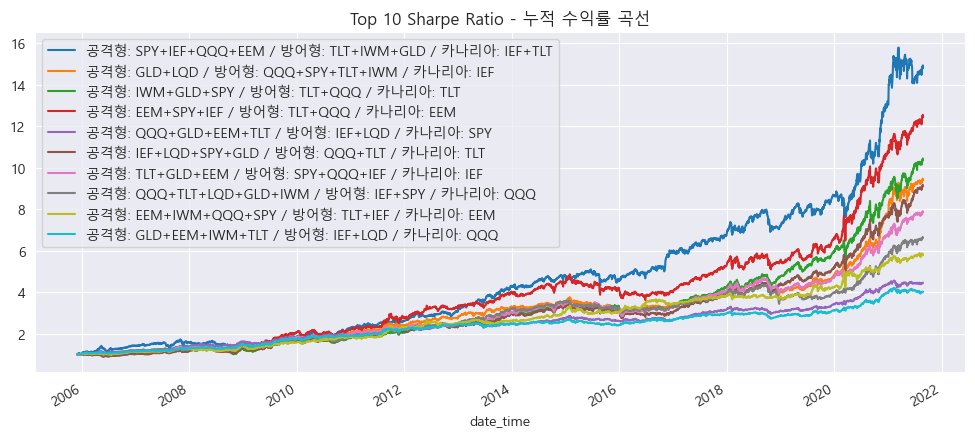

C:\Users\jinwo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


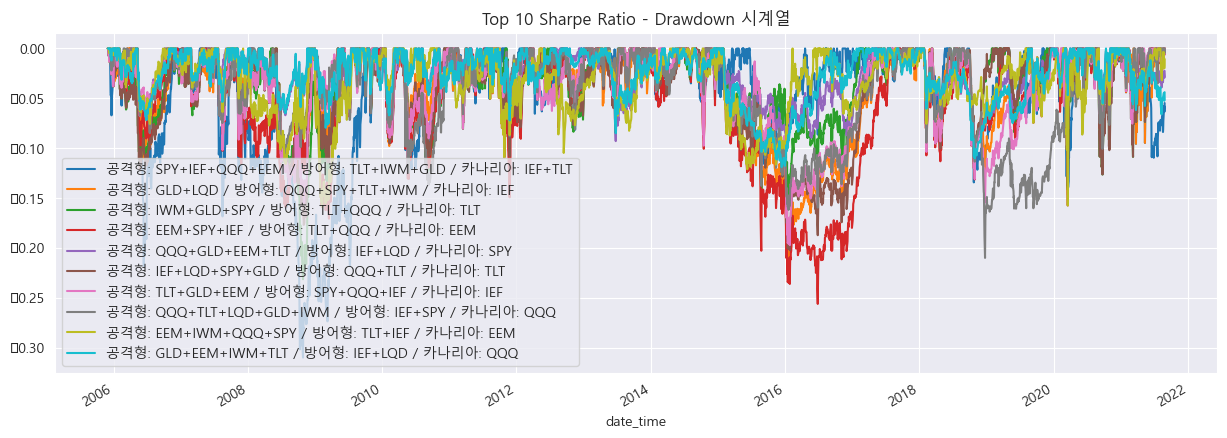


Top 10 MDD 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)
                                                         MDD
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:... -0.309617
공격형: EEM+SPY+IEF / 방어형: TLT+QQQ / 카나리아: EEM        -0.255878
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT        -0.231137
공격형: GLD+LQD / 방어형: QQQ+SPY+TLT+IWM / 카나리아: IEF    -0.225454
공격형: QQQ+TLT+LQD+GLD+IWM / 방어형: IEF+SPY / 카나리아:... -0.209780
공격형: IEF+LQD+SPY+GLD / 방어형: QQQ+TLT / 카나리아: TLT    -0.202017
공격형: TLT+GLD+EEM / 방어형: SPY+QQQ+IEF / 카나리아: IEF    -0.196961
공격형: EEM+IWM+QQQ+SPY / 방어형: TLT+IEF / 카나리아: EEM    -0.158572
공격형: GLD+EEM+IWM+TLT / 방어형: IEF+LQD / 카나리아: QQQ    -0.118799
공격형: QQQ+GLD+EEM+TLT / 방어형: IEF+LQD / 카나리아: SPY    -0.104952

Top 10 MDD 평균 포트폴리오(Sharpe Ration 기반) - 요약 지표 (Top 10)
                                                    drawdown mean
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT                    10
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:...             11
공격형: IEF+LQD+SPY+GLD /

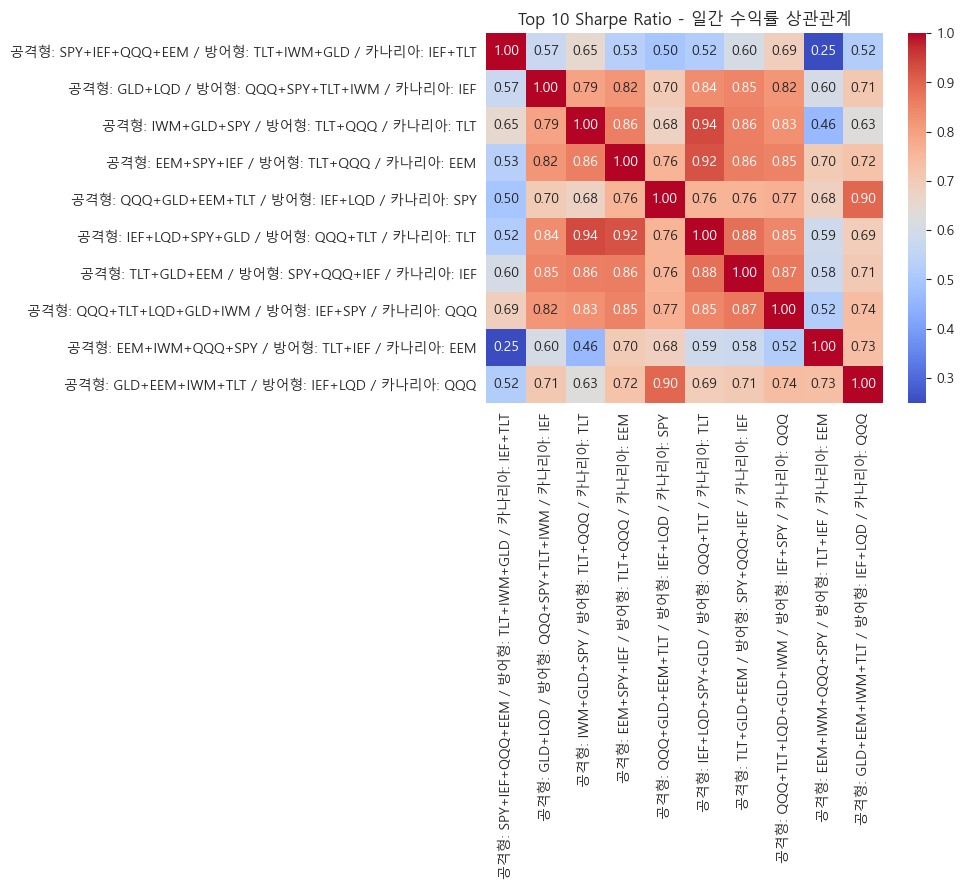


Top 10 CAGR 포트폴리오 - 요약 지표 (Top 10)
                                                        CAGR
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:...  0.185934
공격형: EEM+SPY+IEF / 방어형: TLT+QQQ / 카나리아: EEM         0.173007
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT         0.159506
공격형: GLD+LQD / 방어형: QQQ+SPY+TLT+IWM / 카나리아: IEF     0.152412
공격형: IEF+QQQ+EEM+SPY / 방어형: TLT+IWM / 카나리아: QQQ     0.149992
공격형: IEF+LQD+SPY+GLD / 방어형: QQQ+TLT / 카나리아: TLT     0.149974
공격형: SPY+IEF+LQD+TLT+IWM / 방어형: GLD+QQQ / 카나리아:...  0.149584
공격형: EEM+IEF+LQD / 방어형: QQQ+IWM+GLD / 카나리아: TLT     0.147326
공격형: LQD+GLD / 방어형: IWM+SPY+EEM+TLT+QQQ / 카나리아:...  0.144959
공격형: GLD+IWM / 방어형: IEF+LQD+EEM+SPY+TLT / 카나리아:...  0.139370


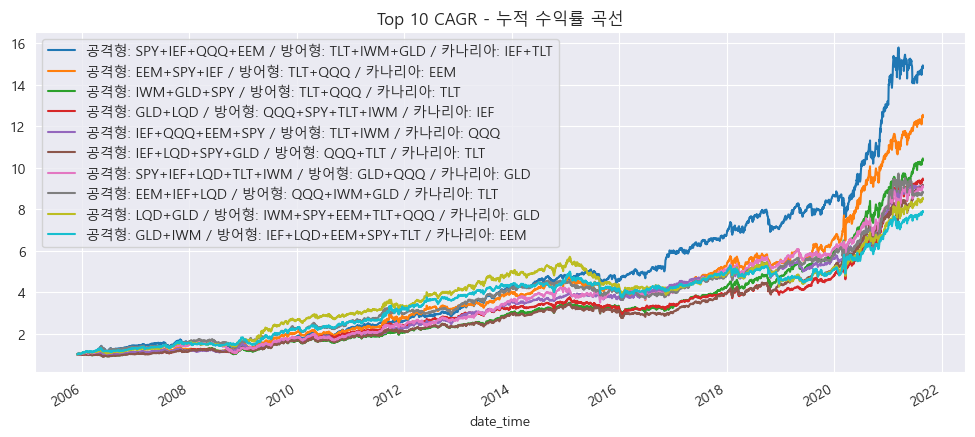

C:\Users\jinwo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


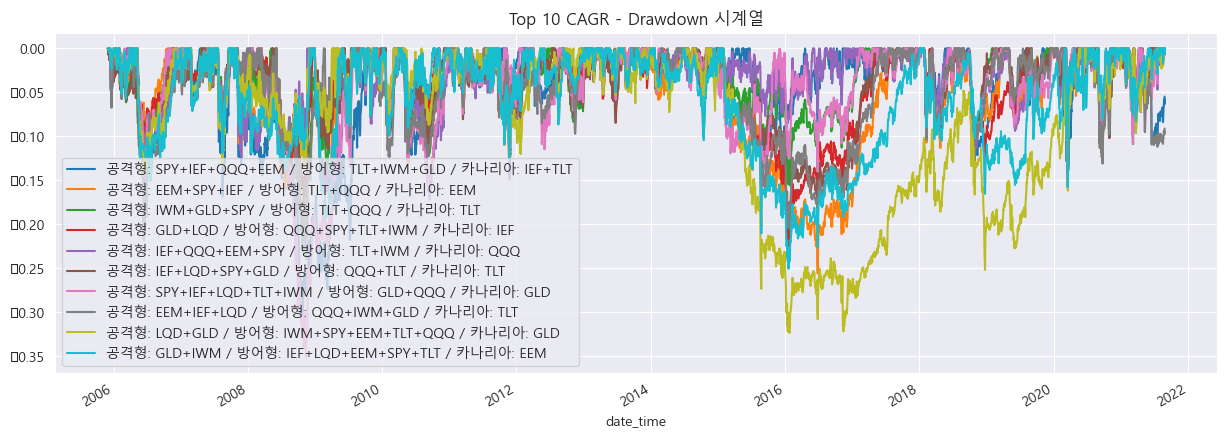


Top 10 MDD 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)
                                                         MDD
공격형: SPY+IEF+LQD+TLT+IWM / 방어형: GLD+QQQ / 카나리아:... -0.351269
공격형: LQD+GLD / 방어형: IWM+SPY+EEM+TLT+QQQ / 카나리아:... -0.323172
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:... -0.309617
공격형: EEM+SPY+IEF / 방어형: TLT+QQQ / 카나리아: EEM        -0.255878
공격형: GLD+IWM / 방어형: IEF+LQD+EEM+SPY+TLT / 카나리아:... -0.250360
공격형: EEM+IEF+LQD / 방어형: QQQ+IWM+GLD / 카나리아: TLT    -0.239233
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT        -0.231137
공격형: GLD+LQD / 방어형: QQQ+SPY+TLT+IWM / 카나리아: IEF    -0.225454
공격형: IEF+LQD+SPY+GLD / 방어형: QQQ+TLT / 카나리아: TLT    -0.202017
공격형: IEF+QQQ+EEM+SPY / 방어형: TLT+IWM / 카나리아: QQQ    -0.171506

Top 10 MDD 평균 포트폴리오(CAGR 기반) - 요약 지표 (Top 10)
                                                    drawdown mean
공격형: IWM+GLD+SPY / 방어형: TLT+QQQ / 카나리아: TLT                    10
공격형: SPY+IEF+QQQ+EEM / 방어형: TLT+IWM+GLD / 카나리아:...             11
공격형: IEF+LQD+SPY+GLD / 방어형: QQQ+TLT / 카나

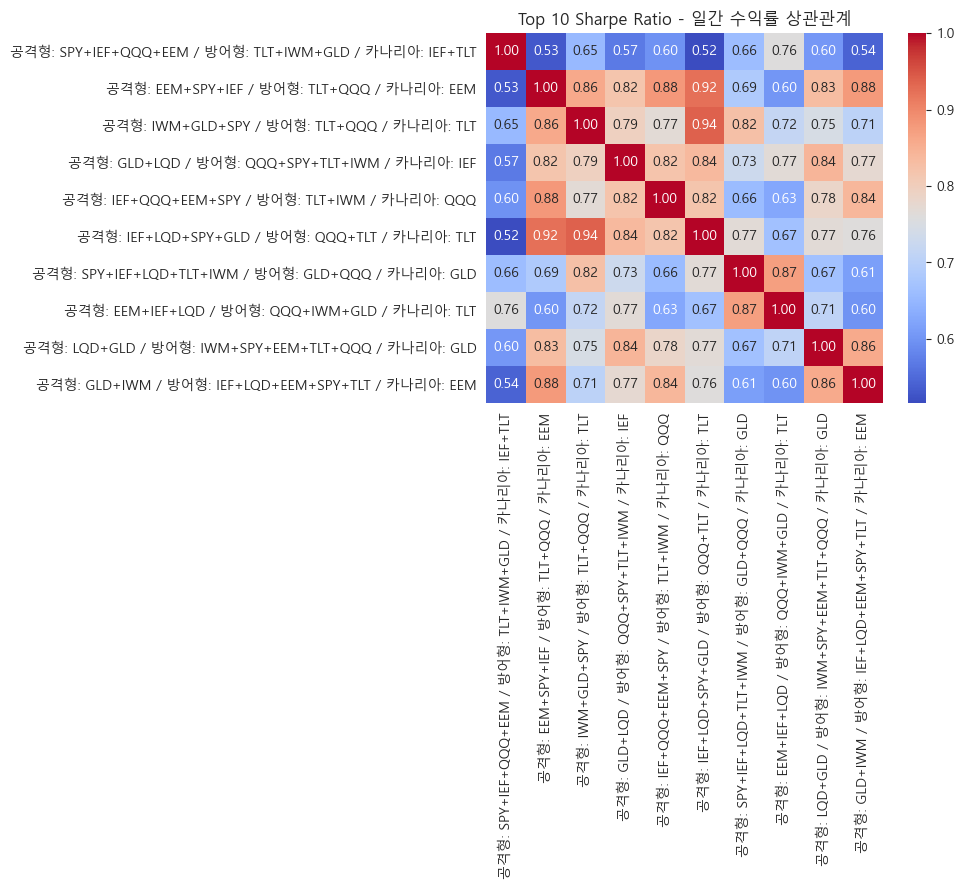

In [45]:
daa_visualize(result_portval_dict, top_10_portval_dict)

In [46]:
result_portval_dict

{'buy_and_hold': date_time
 2002-07-26     1.000000
 2002-07-29     1.019726
 2002-07-30     1.030011
 2002-07-31     1.024395
 2002-08-01     1.001746
                 ...    
 2021-08-23    10.702754
 2021-08-24    10.728472
 2021-08-25    10.734688
 2021-08-26    10.674137
 2021-08-27    10.770138
 Length: 4807, dtype: float64,
 'TLT+LQD+SPY+QQQ+EEM_IEF+IWM_IEF': date_time
 2004-04-30    1.000000
 2004-05-03    1.013140
 2004-05-04    1.018810
 2004-05-05    1.023310
 2004-05-06    1.008370
                 ...   
 2021-08-23    6.919175
 2021-08-24    6.917986
 2021-08-25    6.910288
 2021-08-26    6.888770
 2021-08-27    6.932398
 Length: 4363, dtype: float64,
 'GLD+IEF+IWM_EEM+LQD_TLT': date_time
 2005-11-30    1.000000
 2005-12-01    1.026159
 2005-12-02    1.024970
 2005-12-05    1.033294
 2005-12-06    1.042806
                 ...   
 2021-08-23    3.194682
 2021-08-24    3.188465
 2021-08-25    3.175678
 2021-08-26    3.176103
 2021-08-27    3.199437
 Length: 3963, dtype: fl

In [48]:
top_10_portval_dict['top_10_cagr']

,CAGR
SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT,0.185934
EEM+SPY+IEF_TLT+QQQ_EEM,0.173007
IWM+GLD+SPY_TLT+QQQ_TLT,0.159506
GLD+LQD_QQQ+SPY+TLT+IWM_IEF,0.152412
IEF+QQQ+EEM+SPY_TLT+IWM_QQQ,0.149992
IEF+LQD+SPY+GLD_QQQ+TLT_TLT,0.149974
SPY+IEF+LQD+TLT+IWM_GLD+QQQ_GLD,0.149584
EEM+IEF+LQD_QQQ+IWM+GLD_TLT,0.147326
LQD+GLD_IWM+SPY+EEM+TLT+QQQ_GLD,0.144959
GLD+IWM_IEF+LQD+EEM+SPY+TLT_EEM,0.139370


In [49]:
result_portval_dict['SPY+IEF+QQQ+EEM_TLT+IWM+GLD_IEF+TLT']

date_time
2005-11-30     1.000000
2005-12-01     1.021792
2005-12-02     1.024847
2005-12-05     1.034216
2005-12-06     1.036456
                ...    
2021-08-23    14.822796
2021-08-24    14.857219
2021-08-25    14.881321
2021-08-26    14.790142
2021-08-27    14.928153
Length: 3963, dtype: float64

In [50]:
result_portval_dict['buy_and_hold']

date_time
2002-07-26     1.000000
2002-07-29     1.019726
2002-07-30     1.030011
2002-07-31     1.024395
2002-08-01     1.001746
                ...    
2021-08-23    10.702754
2021-08-24    10.728472
2021-08-25    10.734688
2021-08-26    10.674137
2021-08-27    10.770138
Length: 4807, dtype: float64

In [57]:
from datetime import datetime

now_date = datetime.now().strftime("%Y%m%d")
now_time = datetime.now().strftime("%H%M%S")
print(now_date)
print(now_time)

20251208
193858


In [75]:
import os

os.makedirs("./daa_backtest_outputs", exist_ok=True)
os.makedirs(f"./daa_backtest_outputs/{now_date}", exist_ok=True)

for name, df in top_10_portval_dict.items():

    df.to_parquet(f"daa_backtest_outputs/{now_date}/{name}_{now_time}.parquet", index=True)

    for idx in df.index:

        result_portval_dict[idx].reset_index().rename(columns={0:'value'}).to_parquet(f"daa_backtest_outputs/{now_date}/{idx}_{now_time}.parquet", index=True)